In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6
import poloniex
import time

#TensorFlow
import tensorflow as tf

In [2]:
#Keras
from __future__ import print_function
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.optimizers import Adam

#LSTM
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
polo = poloniex.Poloniex()
polo.timeout = 2
chart_data = polo.returnChartData('USDT_ETH', period= 7200, start=time.time() - polo.DAY * 500, end=time.time())  #データ取得
df = pd.DataFrame(chart_data)  #dataframe化

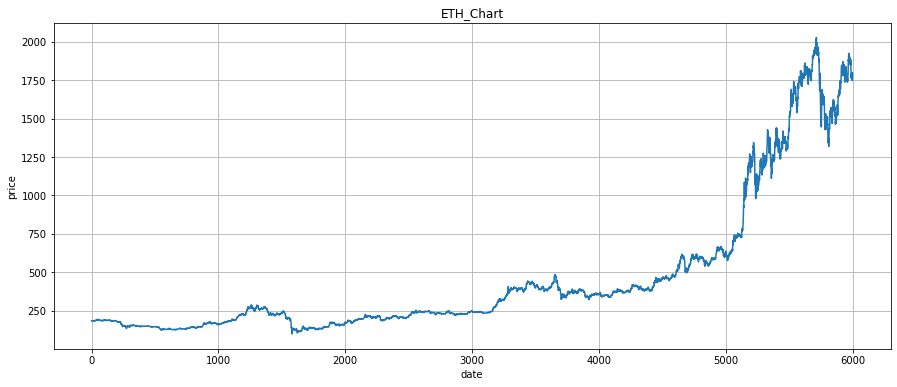

In [4]:
data = df["close"].astype("float32")  # pandasデータはfloat型にしなければならない

#グラフ設定
rcParams['figure.figsize'] = 15, 6
plt.title("ETH_Chart")
plt.xlabel("date")
plt.ylabel("price")
plt.grid(True)

#プロット
plt.plot(data)
plt.show()

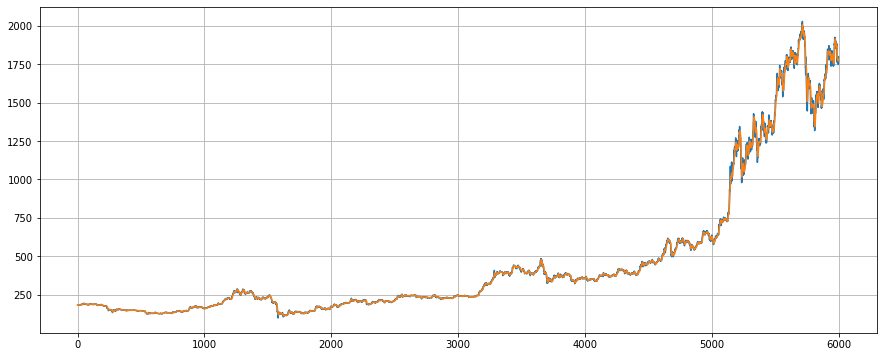

In [6]:
#移動平均
data1 = df["close"].rolling(6).mean()
data1 = data1.fillna(data1[5])

#プロット
plt.plot(data)
plt.plot(data1)

plt.grid(True)
plt.show()

In [8]:
#データから変数とラベルを生成し、訓練データとテストデータに分割する
def data_split(data, v_size=30, train_split_latio=0.7):
    data = data.astype("float32")    #データをfloat32型に変換
    x, t = [], []
    data_len = len(data)    #総データ数
    
    #変数とラベルの生成
    for i in range(data_len - v_size):
        x_valu = data[i : i+v_size]    #連続したmax_len個の値
        t_valu = data[i+v_size]    #x_valuの次の値
        
        x.append(x_valu)    #入力変数ベクトル
        t.append(t_valu)    #出力変数ベクトル

    #ndarray型に変換し形を直す
    x = np.array(x).reshape(data_len-v_size, v_size, 1)
    t = np.array(t).reshape(data_len-v_size, 1)

    #訓練データとテストデータに分割
    border = int(data_len * train_split_latio)    #分割境界値
    x_train, x_test = x[: border], x[border :]    #訓練データ
    t_train, t_test = t[: border], t[border :]     #テストデータ
    
    return x_train, x_test, t_train, t_test

In [10]:
#LSTMモデルの生成
def create_LSTM(v_size, in_size, out_size, hidden_size):
    tf.set_random_seed = (20180822)
    model = Sequential()
    model.add(LSTM(hidden_size, batch_input_shape = (None, v_size, in_size), 
                   recurrent_dropout = 0.5))
    model.add(Dense(out_size))
    model.add(Activation("linear"))
    
    return model

In [12]:
#各パラメータの定義
now_data = data           #扱う元データ
v_size = 30               #入力データ幅
train_split_ratio = 0.7   #訓練データとテストデータの分割割合
x_train, x_test, t_train, t_test= data_split(now_data, v_size, train_split_ratio)  #データの分割

mean = np.mean(x_train)           #平均値の保存
std = np.std(x_train)             #標準偏差の保存
x_train = (x_train - mean) / std  #標準化
x_test = (x_test - mean) / std

tmean = np.mean(t_train)
tstd = np.std(t_train)
t_train = (t_train - tmean) / tstd #出力変数も同じように標準化
t_test = (t_test - tmean) / tstd

in_size = x_train.shape[2]   #入力数
out_size = t_train.shape[1]  #出力数
hidden_size = 300            #隠れ層の数
epochs = 100                 #エポック数
batch_size = 30              #バッチサイズ

In [ ]:
# 学習
early_stopping = EarlyStopping(patience=10)  #ストップカウント                                                              
model = create_LSTM(v_size, in_size, out_size, hidden_size)  #インスタンス生成
model.compile(loss="mean_squared_error", optimizer = Adam(0.0001))  #損失関数定義
model.fit(x_train, t_train, batch_size = batch_size, epochs = epochs, shuffle = True, callbacks = [early_stopping], validation_split = 0.1)  #学習

Train on 3780 samples, validate on 420 samples
Epoch 1/100
